In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
from pathlib import Path
root_path = Path.cwd().parent.absolute()
import sys
sys.path.append(str(root_path))
import os

In [2]:
from architectures.architectures import MLP

from flax import nnx
import jax
from jax._src.tree_util import tree_structure
import jax.numpy as jnp
from jaxtyping import Array

In [3]:
index = 3
device = jax.devices()[index] if jax.devices() else jax.devices('cpu')[0] # If only one gpu change index to 0
print(f"Selected device: {device}")

Selected device: cuda:3


# NODE setup

In [4]:
from architectures.node import NeuralODE

In [5]:
key = jax.random.PRNGKey(0)
rngs = nnx.Rngs(key)
model = MLP(din=2, num_layers=3, width_layers=128, dout=2, activation_fn="tanh", rngs=nnx.Rngs(0))
node = NeuralODE(
    dynamics_model=model,
    time_dependent=False,
    dt0=0.1,
    rtol=1e-4,
    atol=1e-6
)

# Initial condition
y0 = jnp.array([1.0, 0.5])

# Solve from t=0 to t=1
y_final = node(y0, (0.0, 1.0))
print("Final state:", y_final)

Final state: [[0.95567995 0.4358569 ]]


# G Mat

In [6]:
from geometry.G_matrix import G_matrix

In [7]:
G_mat = G_matrix(node)

In [8]:
# # Test
# key = jax.random.PRNGKey(0)
# rngs = nnx.Rngs(key)

# n_samples = 100_000
# d = 2
# z_samples = jax.random.normal(key,(n_samples,d))

# z_samples = jax.device_put(z_samples,device)


In [9]:
# _,params = nnx.split(node)
# key,subkey = jax.random.split(key)
# eta = jax.tree.map(lambda p:jax.random.normal(subkey, p.shape)*10, params) #   jax.numpy.ones(p.shape)
# eta = jax.tree.map(lambda p: jax.device_put(p,device), eta)
# key,subkey = jax.random.split(key)
# epsilon = jax.tree.map(lambda p: jax.random.normal(subkey, p.shape)*0.1, params)
# eta_pert = jax.tree.map(lambda e,ep: e+ep, eta, epsilon)

In [10]:
# # Compute G_hat@eta
# result = G_mat.mvp(z_samples, eta)

In [11]:
# key,subkey = jax.random.split(key)
# z_samples = jax.random.normal(subkey,(n_samples,d))
# z_samples = jax.device_put(z_samples,device)

# # Test solver 
# result_solver, _ = G_mat.solve_system(z_samples, result, tol=1e-6, maxiter=20,x0 = eta_pert, method="minres")

In [12]:
# jax.tree.map(lambda x,y: jnp.linalg.norm(x-y)/jnp.linalg.norm(y), result_solver, eta)

In [13]:
# verify_result = G_mat.mvp(z_samples, result_solver)
# jax.tree.leaves(jax.tree.map(lambda x,y: jnp.linalg.norm(x-y)/jnp.linalg.norm(y), result, verify_result))

# Gradient flow test

# General form

In [14]:
from functionals.functions import double_well_potential_fn,create_potentials
from functionals.linear_funcitonal_class import LinearPotential

In [15]:
from flows.gradient_flow import run_gradient_flow
from flows.visualization import visualize_gradient_flow_results

In [ ]:
def gradient_flow_step_with_potential(node: nnx.Module, z_samples: Array, G_mat: G_matrix,
                                    potential: LinearPotential, step_size: float = 0.01,
                                    solver_tol: float = 1e-6, solver_maxiter: int = 50,
                                    use_regularization: bool = True) -> tuple[nnx.Module, dict]:
    """
    Generic gradient flow step that works with any LinearPotential
    
    Args:
        node: Current Neural ODE model
        z_samples: Reference samples for Monte Carlo estimation
        G_mat: G-matrix object for linear system solving
        potential: LinearPotential instance
        step_size: Gradient flow step size h
        solver_tol: Tolerance for linear solver
        solver_maxiter: Maximum iterations for linear solver
        use_regularization: Whether to use regularized CG solver
        
    Returns:
        updated_node: Node with updated parameters
        step_info: Dictionary with step diagnostics
    """
    
    # Get current parameters
    _, current_params = nnx.split(node)
    
    # Compute energy gradient using the potential
    energy_grad = potential.compute_energy_gradient(node, z_samples, current_params)
    
    # Solve linear system: G(θ) η = -∇_θ F(θ)
    neg_energy_grad = jax.tree.map(lambda x: -x, energy_grad)
    
    if use_regularization:
        # Use regularized CG solver
        def regularized_matvec(eta):
            return jax.tree.map(lambda x, y: x + 1e-6 * y, 
                               G_mat.mvp(z_samples, eta, current_params), eta)
        
        from jax.scipy.sparse.linalg import cg
        eta, solver_info_raw = cg(regularized_matvec, neg_energy_grad, 
                                 tol=solver_tol, maxiter=solver_maxiter)
        
        # solver_info = {
        #     'success': solver_info_raw.info == 0,
        #     'iterations': solver_info_raw.nit,
        #     'norm_res': solver_info_raw.info
        # }
    else:
        # Use MINRES solver
        eta, solver_info = G_mat.solve_system(z_samples, neg_energy_grad,
                                             params=current_params,
                                             tol=solver_tol, 
                                             maxiter=solver_maxiter,
                                             method="minres")
    
    # Update parameters: θ^{k+1} = θ^k + h * η
    updated_params = jax.tree.map(lambda p, e: p + step_size * e, current_params, eta)
    
    # Create updated node
    graphdef, _ = nnx.split(node)
    updated_node = nnx.merge(graphdef, updated_params)
    
    # Compute diagnostics
    grad_norm = jnp.sqrt(sum(jax.tree.leaves(jax.tree.map(lambda x: jnp.sum(x**2), energy_grad))))
    eta_norm = jnp.sqrt(sum(jax.tree.leaves(jax.tree.map(lambda x: jnp.sum(x**2), eta))))
    param_norm = jnp.sqrt(sum(jax.tree.leaves(jax.tree.map(lambda x: jnp.sum(x**2), updated_params))))
    
    step_info.update({
        'gradient_norm': grad_norm,
        'eta_norm': eta_norm,
        'param_norm': param_norm,
        'step_size': step_size
    })
    
    return updated_node, step_info

In [17]:
# # Gradient Flow Integration with LinearPotential

# def run_gradient_flow(node: nnx.Module, z_samples: Array, G_mat: G_matrix,
#                      potential: LinearPotential, h: float = 0.01, 
#                      max_iterations: int = 100, tolerance: float = 1e-6,
#                      use_regularization: bool = True, 
#                      progress_every: int = 10) -> dict:
#     """
#     Run complete gradient flow integration with any LinearPotential
    
#     Args:
#         node: Initial Neural ODE model
#         z_samples: Reference samples for Monte Carlo estimation
#         G_mat: G-matrix object for linear system solving
#         potential: LinearPotential instance defining the energy functional
#         h: Time step size
#         max_iterations: Maximum number of gradient flow steps
#         tolerance: Convergence tolerance for energy
#         use_regularization: Whether to use regularized CG solver
#         progress_every: Print progress every N iterations
        
#     Returns:
#         results: Dictionary containing energy history, solver stats, etc.
#     """
    
#     print(f"Starting gradient flow with {potential.__class__.__name__}...")
#     print(f"Potential function: {potential.potential_fn.__name__}")
#     print(f"Potential parameters: {potential.potential_kwargs}")
    
#     # Initialize tracking
#     energy_history = []
#     solver_stats = []
#     param_norms = []
#     sample_history = []  # Store samples at key iterations for visualization
    
#     # Initial state
#     _, current_params = nnx.split(node)
#     current_energy, current_samples = potential.evaluate_energy(node, z_samples, current_params)
#     energy_history.append(float(current_energy))
#     sample_history.append(current_samples)
    
#     print(f"Initial energy: {current_energy:.6f}")
#     print(f"Target: minimize energy functional")
    
#     # Main integration loop
#     current_node = node

#     #Initialize key for sample generation
#     key = jax.random.PRNGKey(0)
#     n_samples = len(z_samples)
    
#     for iteration in range(max_iterations):
        
#         key,subkey= jax.random.split(key)
#         z_samples_eval = jax.random.normal(subkey,(n_samples,2))
#         z_samples_eval = jax.device_put(z_samples_eval,device)
#         # Perform gradient flow step
#         current_node, step_info = gradient_flow_step_with_potential(
#             current_node, z_samples_eval, G_mat, potential,
#             step_size=h, 
#             solver_tol=tolerance,
#             use_regularization=use_regularization
#         )
        
#         # Evaluate new energy
#         _, current_params = nnx.split(current_node)
#         current_energy, current_samples = potential.evaluate_energy(current_node, z_samples, current_params)
        
#         # Store diagnostics
#         energy_history.append(float(current_energy))
#         solver_stats.append(step_info)
#         param_norm = jnp.sqrt(sum(jax.tree.leaves(jax.tree.map(lambda x: jnp.sum(x**2), current_params))))
#         param_norms.append(float(param_norm))
        
#         # Store samples for visualization at regular intervals
#         if iteration % progress_every == 0 or iteration == max_iterations - 1:
#             sample_history.append(current_samples)
        
#         # Progress reporting
#         if iteration % progress_every == 0 :
#             energy_decrease = energy_history[0] - current_energy
#             print(f"Iter {iteration:3d}: Energy = {current_energy:.6f}, "
#                   f"Decrease = {energy_decrease:.6f}, "
#                   f"Grad norm: {step_info['gradient_norm']:.2e}")
#             plt.scatter(current_samples[:,0], current_samples[:,1], s = 10, alpha = 0.3)
#             plt.show()
        
#         # Early stopping conditions
#         if current_energy < tolerance:
#             print(f"✓ Converged! Energy below tolerance at iteration {iteration}")
#             break
            
                    
#         if iteration > 5 and abs(energy_history[-1] - energy_history[-2]) < tolerance * 1e-2:
#             print(f"✓ Energy converged at iteration {iteration}")
#             break
    
#     # Final summary
#     final_energy = energy_history[-1]
#     total_decrease = energy_history[0] - final_energy
    
#     print(f"\n=== Integration Complete ===")
#     print(f"Total iterations:    {len(energy_history)-1}")
#     print(f"Initial energy:      {energy_history[0]:.6f}")
#     print(f"Final energy:        {final_energy:.6f}")
#     print(f"Total decrease:      {total_decrease:.6f}")
#     print(f"Reduction ratio:     {final_energy/energy_history[0]:.4f}")
#     print(f"Final param norm:    {param_norms[-1]:.6f}")
    
#     return {
#         'final_node': current_node,
#         'energy_history': energy_history,
#         'param_norms': param_norms,
#         'sample_history': sample_history,
#         'potential': potential,
#         'convergence_info': {
#             'converged': final_energy < tolerance or abs(energy_history[-1] - energy_history[-2]) < tolerance * 1e-2,
#             'final_energy': final_energy,
#             'total_decrease': total_decrease,
#             'iterations': len(energy_history) - 1
#         }
#     }


# # Example usage for different potentials
# def test_gradient_flows():
#     """
#     Test gradient flow with different potentials
#     """
    
#     # Setup (assuming you have these from previous cells)
#     # node, z_samples, G_mat_flow should be defined
    
#     # Create potentials
#     potentials = create_potentials()
    
#     # Test 1: Quadratic potential
#     print("="*50)
#     print("TESTING QUADRATIC POTENTIAL")
#     print("="*50)
    
#     quadratic_results = run_gradient_flow(
#         gradient_flow_node, z_samples, G_mat_flow,
#         potentials['quadratic'],
#         h=0.1, max_iterations=50, tolerance=1e-6
#     )
    
#     # Test 2: Double-well potential  
#     print("\n" + "="*50)
#     print("TESTING DOUBLE-WELL POTENTIAL")
#     print("="*50)
    
#     double_well_results = run_gradient_flow(
#         gradient_flow_node, z_samples, G_mat_flow, 
#         potentials['double_well'],
#         h=0.05, max_iterations=100, tolerance=1e-6
#     )
    
#     # Visualize results
#     print("\nVisualizing quadratic potential results...")
#     visualize_gradient_flow_results(quadratic_results)
    
#     print("\nVisualizing double-well potential results...")
#     visualize_gradient_flow_results(double_well_results)
    
#     return quadratic_results, double_well_results

In [18]:
# Create potentials
potentials = create_potentials()

In [19]:
# Gradient flow parameters
h = 1e-2 # Time step size
max_iterations = 100
tolerance = 1e-6
n_samples = 2_000  # Monte Carlo sample size


key = jax.random.PRNGKey(0)
rngs = nnx.Rngs(key)

# Create NODE model
gradient_flow_model = MLP(din=2, num_layers=1, width_layers=32, dout=2, 
                         activation_fn="tanh", rngs=rngs)
gradient_flow_node = NeuralODE(
    dynamics_model=gradient_flow_model,
    time_dependent=False,
    dt0=0.1,
)

# Set parameters to be very small (near zero)
_, initial_params = nnx.split(gradient_flow_node)
scale_factor = 1e-2  # Small scaling to keep near identity

# Scale all parameters to be small
small_params = jax.tree.map(lambda p: p * scale_factor, initial_params)

# Merge back into the node
graphdef, _ = nnx.split(gradient_flow_node)
gradient_flow_node = nnx.merge(graphdef, small_params)

# Generate reference samples from λ = N(0, I)
key, subkey = jax.random.split(key)
z_samples = jax.random.normal(subkey, (n_samples, 2))

G_mat_flow = G_matrix(gradient_flow_node)

potential = potentials['double_well']


Starting gradient flow with LinearPotential...
Potential function: double_well_potential_fn
Potential parameters: {'alpha': 1.0}
Selected device: cuda:0
Initial energy: 3.233054
Target: minimize energy functional


2025-08-27 12:19:05.663128: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


Iter   0: Energy = 3.230959, Decrease = 0.002095, Grad norm: 1.92e-01


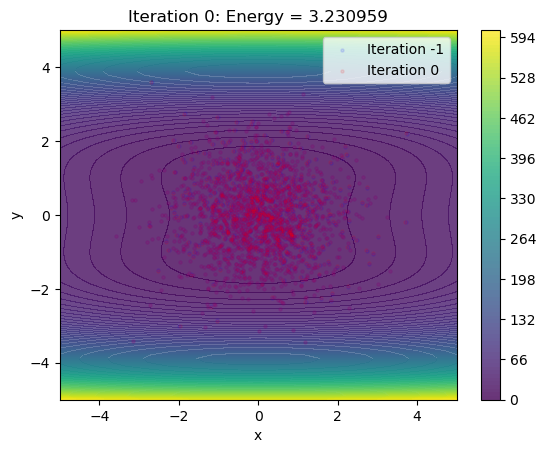

Iter  10: Energy = 1.794987, Decrease = 1.438067, Grad norm: 1.21e+00


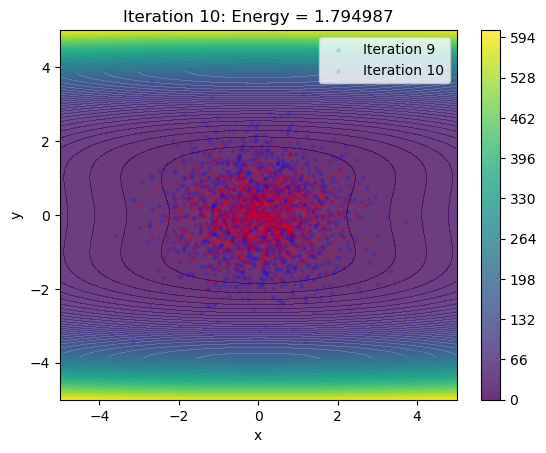

Iter  20: Energy = 1.376274, Decrease = 1.856780, Grad norm: 8.30e-01


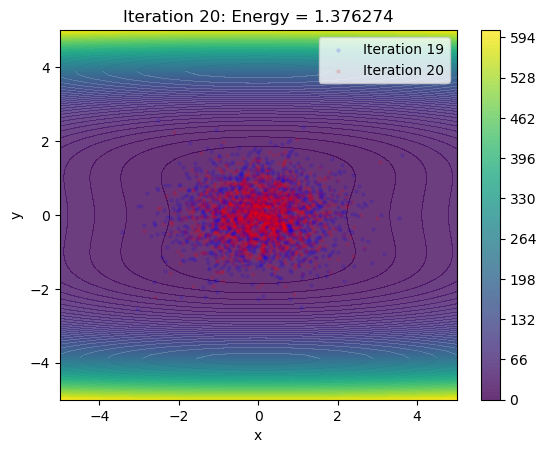

Iter  30: Energy = 1.131158, Decrease = 2.101896, Grad norm: 8.21e-01


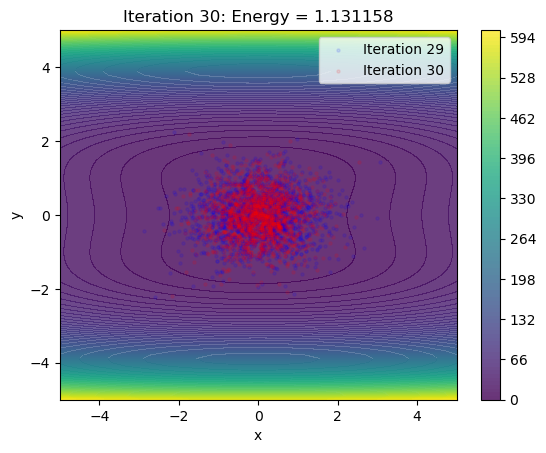

Iter  40: Energy = 0.976186, Decrease = 2.256868, Grad norm: 6.09e-01


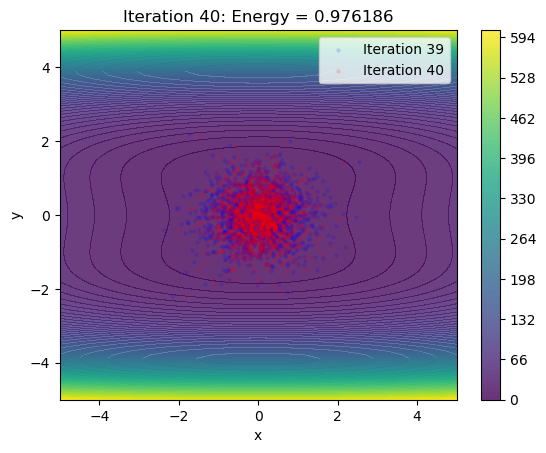

Iter  50: Energy = 0.874946, Decrease = 2.358109, Grad norm: 4.77e-01


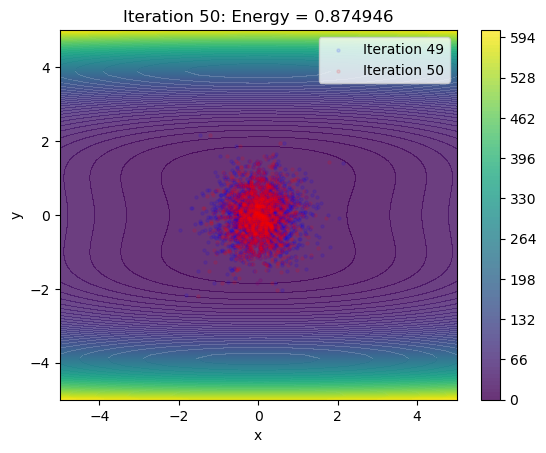

Iter  60: Energy = 0.806180, Decrease = 2.426875, Grad norm: 3.71e-01


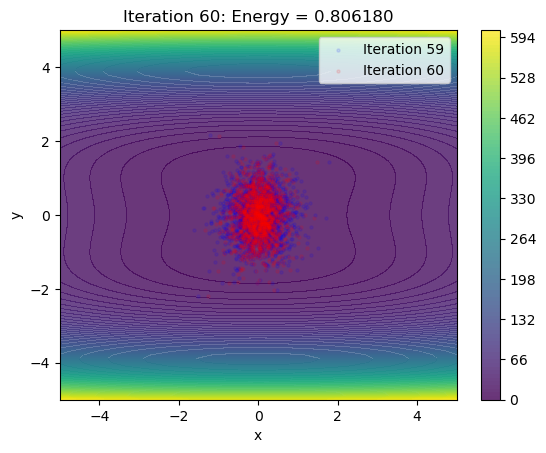

Iter  70: Energy = 0.762917, Decrease = 2.470138, Grad norm: 2.65e-01


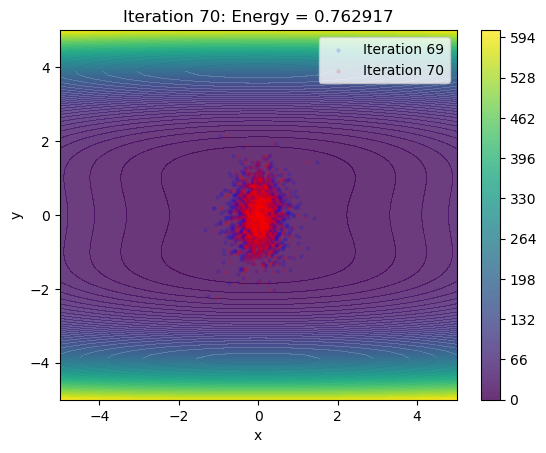

Iter  80: Energy = 0.736085, Decrease = 2.496970, Grad norm: 2.07e-01


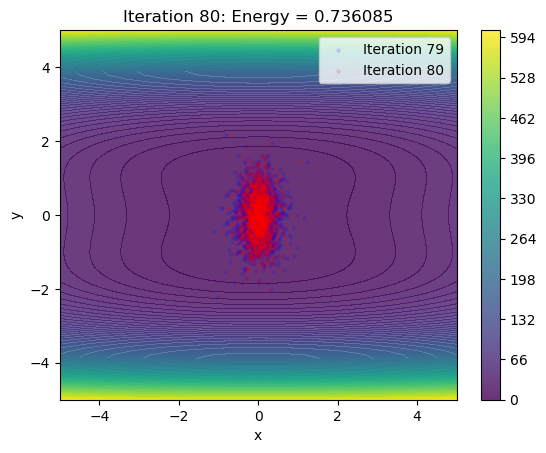

Iter  90: Energy = 0.721794, Decrease = 2.511261, Grad norm: 1.96e-01


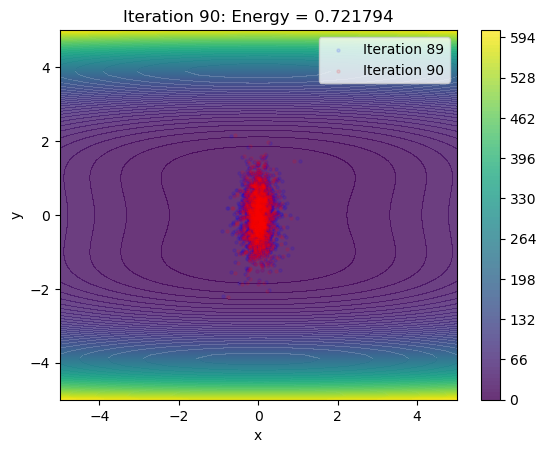


=== Integration Complete ===
Total iterations:    101
Initial energy:      3.233054
Final energy:        0.712225
Total decrease:      2.520829
Reduction ratio:     0.2203
Final param norm:    2.265299


In [20]:

double_well_results = run_gradient_flow(
    gradient_flow_node, z_samples, G_mat_flow,
    potential,
    h=h, max_iterations=max_iterations, tolerance=tolerance
)

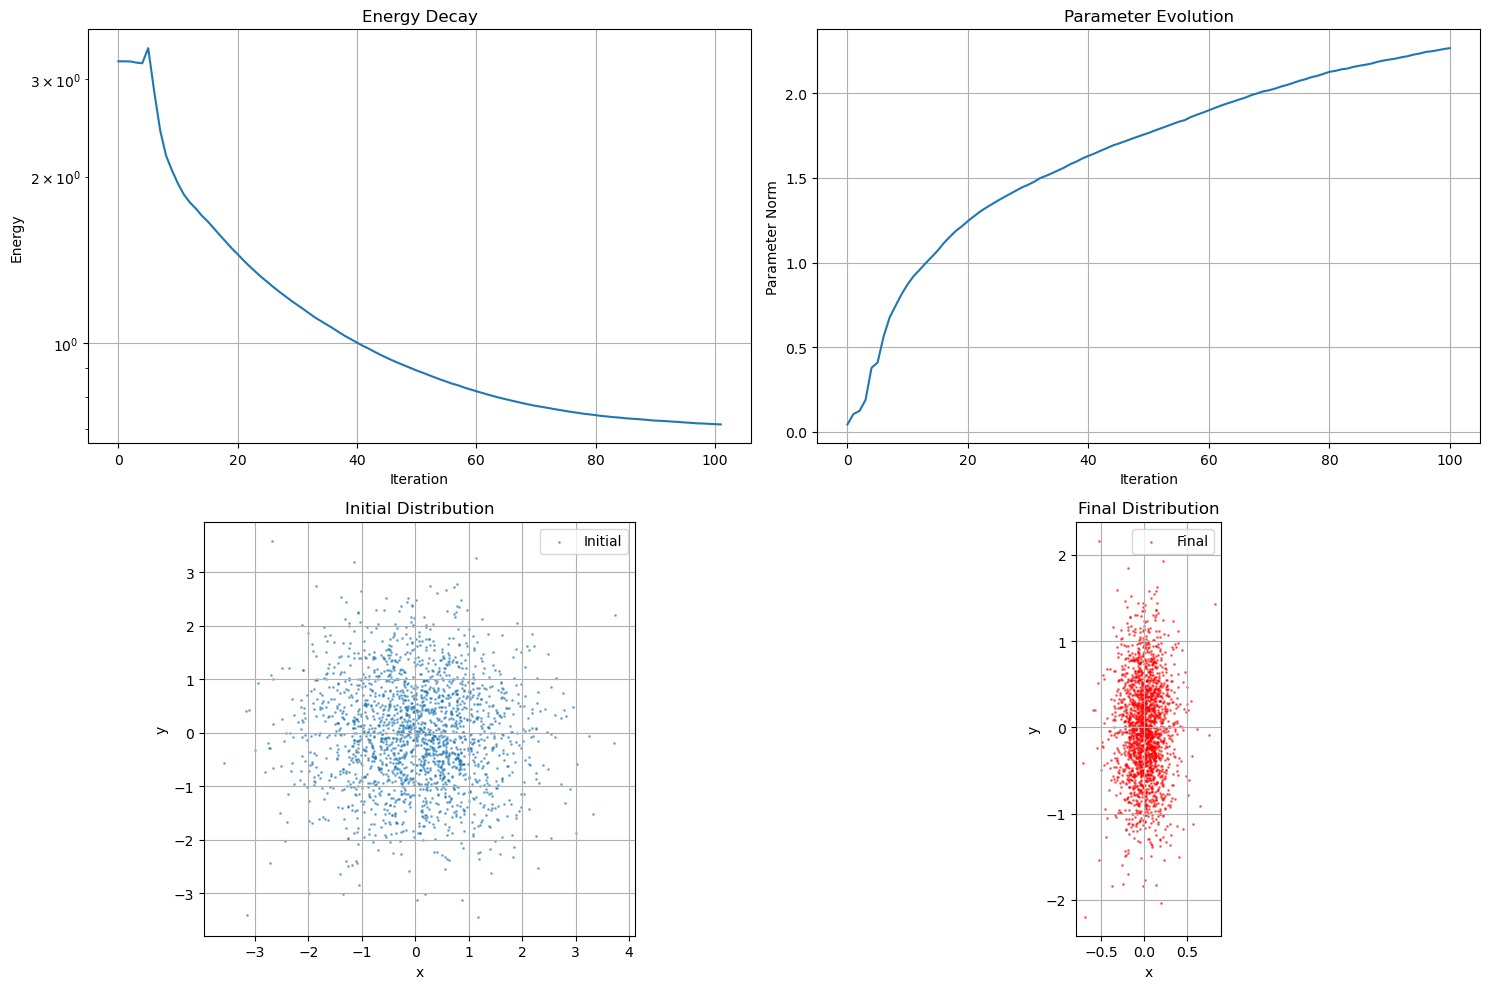

In [21]:
# Visualize results
visualize_gradient_flow_results(double_well_results)